In [ ]:
!pip install shap

from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error, r2_score

# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import pandas as pd

dataset = fetch_california_housing(as_frame = True)
X = dataset['data']
y = dataset['target']

X1 = StandardScaler().fit_transform(X)
X = pd.DataFrame(X1, columns=X.columns)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [ ]:
X_train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-0.007901,-0.000862,0.000732,0.005771,0.000621,-0.004275,0.004345,-0.002366
std,1.001465,0.999477,1.050939,1.070296,1.009785,0.618925,1.001543,1.001168
min,-1.774299,-2.196180,-1.852319,-1.610768,-1.256123,-0.223445,-1.447568,-2.385992
25%,-0.696396,-0.845393,-0.404995,-0.191775,-0.562926,-0.061682,-0.792107,-1.113209
50%,-0.186191,0.028646,-0.085143,-0.101171,-0.229132,-0.024379,-0.642287,0.533922
75%,0.451437,0.664310,0.249344,0.005979,0.266261,0.020488,0.977638,0.778496
max,5.858286,1.856182,55.163236,69.571713,30.250330,57.448030,2.958068,2.625280


In [ ]:
y[20:60]

20    1.475
21    1.598
22    1.139
23    0.997
24    1.326
25    1.075
26    0.938
27    1.055
28    1.089
29    1.320
30    1.223
31    1.152
32    1.104
33    1.049
34    1.097
35    0.972
36    1.045
37    1.039
38    1.914
39    1.760
40    1.554
41    1.500
42    1.188
43    1.888
44    1.844
45    1.823
46    1.425
47    1.375
48    1.875
49    1.125
50    1.719
51    0.938
52    0.975
53    1.042
54    0.875
55    0.831
56    0.875
57    0.853
58    0.803
59    0.600
Name: MedHouseVal, dtype: float64

## Modelos Interpretáveis e PDP Plots

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print( np.sqrt(mean_squared_error(y_test, pred)) )
print( r2_score(y_test, pred) )

0.726534556757837
0.6075494500520069


In [ ]:
print(lr.coef_)
print(X_train.columns)

[ 0.82207764  0.11487438 -0.24719642  0.2797003  -0.00490703 -0.04872479
 -0.89397738 -0.86574611]
Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')


In [ ]:
lr = Lasso(alpha=0.02, max_iter=10000)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print( np.sqrt(mean_squared_error(y_test, pred)) )
print( r2_score(y_test, pred) )
print(lr.coef_)
print(X_train.columns[np.nonzero(lr.coef_)])

0.7480742553951831
0.5839344017612896
[ 0.72738679  0.12461538 -0.          0.03242785 -0.         -0.00324237
 -0.68331928 -0.64153085]
Index(['MedInc', 'HouseAge', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude'], dtype='object')


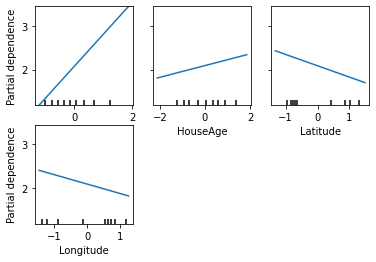

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(lr, X_test, ['MedInc', 'HouseAge', 'Latitude', 'Longitude'])
plt.show()

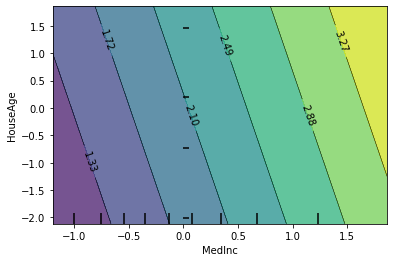

In [ ]:
PartialDependenceDisplay.from_estimator(lr, X_test, [('MedInc', 'HouseAge')])
plt.show()


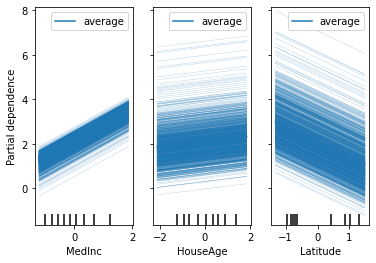

In [ ]:
PartialDependenceDisplay.from_estimator(lr, X_test, ['MedInc', 'HouseAge', 'Latitude'], kind='both')
plt.show()

## XGBoost e SHAP Values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=7)
X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, test_size=0.25, random_state=7)

d_train = xgboost.DMatrix(X_train, label=y_train)
d_vali = xgboost.DMatrix(X_vali, label=y_vali)
d_test = xgboost.DMatrix(X_test, label=y_test)

params = {
    "eta": 0.01,
    "subsample": 0.5,
}
model = xgboost.train(params, d_train, 5000, evals = [(d_vali, "vali")], verbose_eval=100, early_stopping_rounds=20)

[0]	vali-rmse:1.94322
Will train until vali-rmse hasn't improved in 20 rounds.
[100]	vali-rmse:0.923345
[200]	vali-rmse:0.626646
[300]	vali-rmse:0.544183
[400]	vali-rmse:0.512361
[500]	vali-rmse:0.499696
[600]	vali-rmse:0.492866
[700]	vali-rmse:0.488211
[800]	vali-rmse:0.484484
[900]	vali-rmse:0.480891
[1000]	vali-rmse:0.478274
[1100]	vali-rmse:0.475992
[1200]	vali-rmse:0.473443
[1300]	vali-rmse:0.471706
[1400]	vali-rmse:0.470488
[1500]	vali-rmse:0.469264
[1600]	vali-rmse:0.467915
[1700]	vali-rmse:0.466616
[1800]	vali-rmse:0.46518
[1900]	vali-rmse:0.464412
[2000]	vali-rmse:0.463371
[2100]	vali-rmse:0.462625
[2200]	vali-rmse:0.461958
[2300]	vali-rmse:0.461198
[2400]	vali-rmse:0.460483
[2500]	vali-rmse:0.460093
[2600]	vali-rmse:0.459454
[2700]	vali-rmse:0.459137
Stopping. Best iteration:
[2760]	vali-rmse:0.458895



In [ ]:
pred = model.predict(d_test)

print( np.sqrt(mean_squared_error(d_test.get_label(), pred)) )
print( r2_score(d_test.get_label(), pred) )

0.464581
0.8395294690571405


In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
X_shap = X_test[0:1000]
shap_values = explainer.shap_values(X_shap)

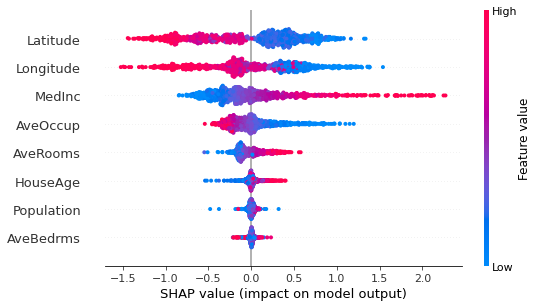

In [ ]:
shap.summary_plot(shap_values, X_shap)

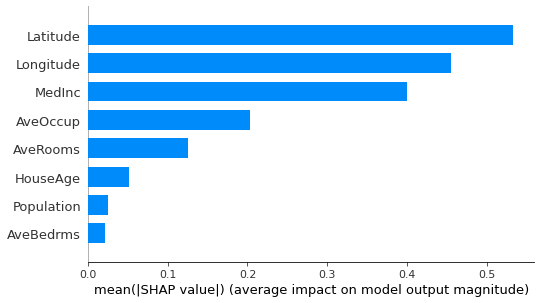

In [ ]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_shap.iloc[0,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[2,:], X_shap.iloc[2,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[900:1000,:], X_shap.iloc[:100,:])

In [ ]:
X_train.columns[0:-1]

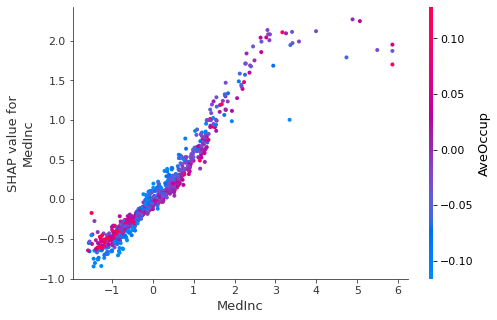

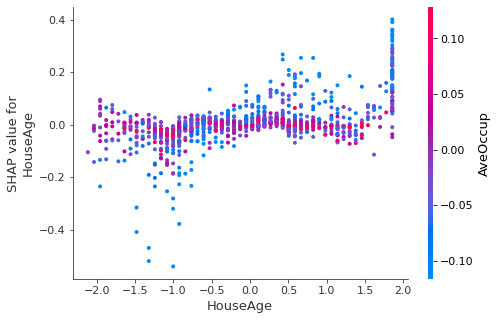

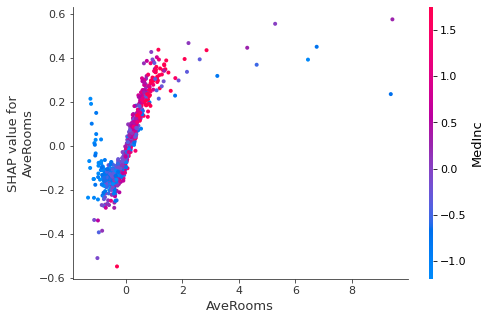

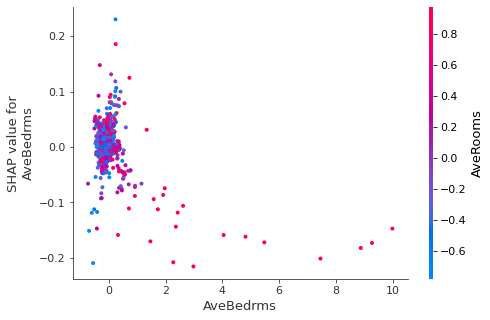

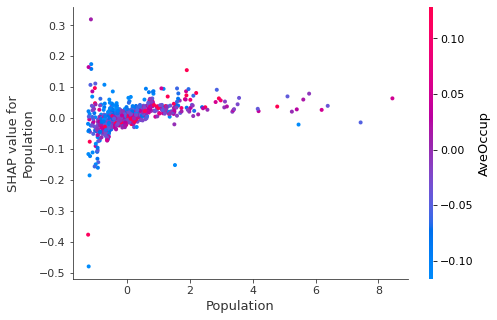

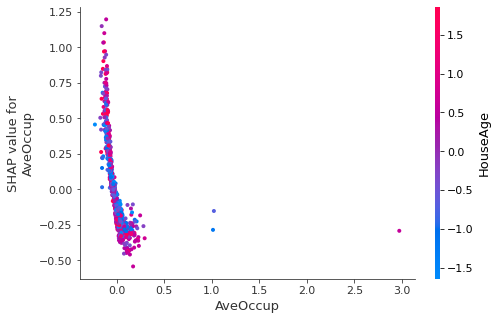

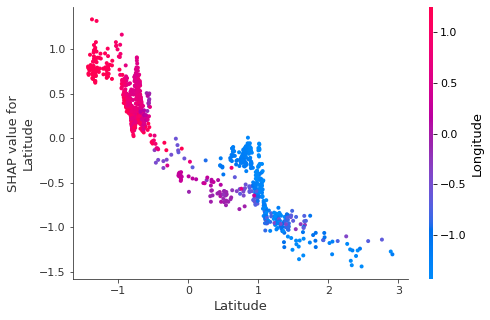

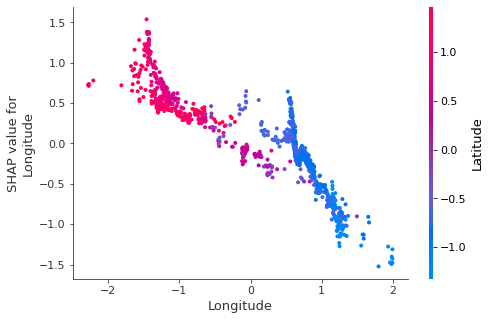

In [ ]:
shap.initjs()
for name in X.columns:
    shap.dependence_plot(name, shap_values, X_shap, display_features=X_shap)

In [ ]:
explainer1 = shap.TreeExplainer(model, X_shap)

In [ ]:
shap_values1 = explainer1.shap_values(X_shap)

 98%|===================| 196/200 [00:55<00:01]       

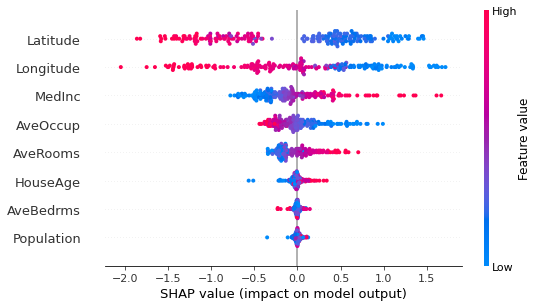

In [ ]:
shap.summary_plot(shap_values1, X_shap)

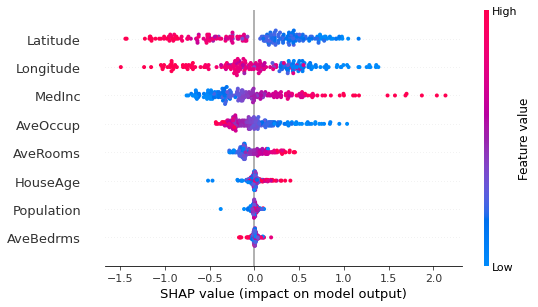

In [ ]:
shap.summary_plot(shap_values, X_shap)